In [86]:
from qiskit import *
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
import numpy as np
from matplotlib import pyplot as plt
import math
from qiskit.circuit import Parameter, ParameterVector
from qiskit import Aer, transpile
from scipy.optimize import minimize
import torch
from torch import Tensor
from torch.optim import Adam, LBFGS
from torch.nn import MSELoss
from qiskit.utils import algorithm_globals
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector



from qiskit.algorithms.optimizers import ADAM

backend=Aer.get_backend('qasm_simulator')

In [87]:
class dqc:
    def __init__(self, qubit, depth, backend, x, Lambda, kappa):
        self.featuremap=self.ChebyshevTower
        self.qubit=qubit
        self.depth=depth
        self.backend=backend
        self.x=x
        self.Lambda=Lambda
        self.kappa=kappa
        self.intermediate_result=[]
    def qcirc(self):
        qr=QuantumRegister(self.qubit)
        cr=ClassicalRegister(self.qubit)
        quantumcircuit=QuantumCircuit(qr,cr)
        return quantumcircuit
    def measure(self, circuit):
        for i in range(circuit.num_qubits):
            circuit.measure(i,i)
    def qnn(self):
        qr=QuantumRegister(self.qubit)
        cr=ClassicalRegister(self.qubit)
        qc=QuantumCircuit(qr,cr)
        input=Parameter('x')
        theta=ParameterVector('theta', self.qubit*self.depth*3)
        for i in range(self.qubit):
            qc.ry(2*(i+1)*input.arccos(),i)
        qc.barrier(qr)
        for d in range(self.depth):
            for i in range(self.qubit):
                qc.rz(theta[3*(i+self.qubit*d)],i)
                qc.rx(theta[3*(i+self.qubit*d)+1],i)
                qc.rz(theta[3*(i+self.qubit*d)+2],i)
            for i in range(0, self.qubit-1):
                qc.cx(i, i+1)
        return qc, input, theta
    # featuremap
    def ProductFeatureMap(self,input):
        qc=self.qcirc()
        x=Parameter(f"{input}")
        for i in range(self.qubit):
            qc.ry(x, i)
        bc=qc.bind_parameters({x:math.asin(input)})
        return bc
    def Chebyshev(self,input):
        qc=self.qcirc()
        x=Parameter(f"{input}")
        for i in range(self.qubit):
            qc.ry(x,i)
        bc=qc.bind_parameters({x:2*math.acos(input)})
        return bc
    def ChebyshevTower(self, input):
        qc=self.qcirc()
        x=Parameter(f"{input}")
        for i in range(self.qubit):
            qc.ry((i)*x,i)
            #qc.ry((i+1)*x,i)
        bc=qc.bind_parameters({x:2*math.acos(input)})
        return bc
    def Ansatz(self, theta):
        qc=self.qcirc()
        for d in range(self.depth):
            for i in range(self.qubit):
                qc.rz(theta[3*(i+self.qubit*d)],i)
                qc.rx(theta[3*(i+self.qubit*d)+1],i)
                qc.rz(theta[3*(i+self.qubit*d)+2],i)
            for i in range(0, self.qubit-1):
                qc.cx(i, i+1)
        return qc
    def circuit_expectation(self,counts):
        exp=[]
        for i in range(self.qubit):
            for j, k in counts.items():
                prob=(k/self.backend.options.shots)**2
                if j[i]=='0':
                    eigenvalue=1
                if j[i]=='1':
                    eigenvalue=-1
                exp.append(eigenvalue*prob)
        expectation=sum(exp)
        return expectation
    def f(self, input, theta): 
        qr=QuantumRegister(self.qubit) 
        cr=ClassicalRegister(self.qubit)
        qc=QuantumCircuit(qr, cr)
        fm=self.featuremap(input)
        feature=qc.compose(fm)
        ansatz=self.Ansatz(theta)
        dqc=feature.compose(ansatz)
        dqc.barrier(qr)
        self.measure(dqc)
        counts=self.backend.run(transpile(dqc, self.backend)).result().get_counts()
        fx=self.circuit_expectation(counts) 
        return fx
    def separate_featuremap(self, order, shift, input):
        qr=QuantumRegister(self.qubit)
        cr=ClassicalRegister(self.qubit)
        qc=QuantumCircuit(qr, cr)
        x=Parameter(f"{input}")
        for i in range(self.qubit):
            if i==order:
                qc.ry(x+shift,i)
            if i!= order:
                qc.ry(x,i)
        if self.featuremap==self.ProductFeatureMap:
            mapping=math.asin(input)
        else:
            mapping=2*math.acos(input)
        bc=qc.bind_parameters({x:mapping})
        return bc, qr
    def f_shift_expectation_sum(self, shift, input, theta):
            f_shift_expectation_sum=[]
            for i in range(self.qubit):
                qc, qr_1=self.separate_featuremap(order=i, shift=shift, input=input)
                ansatz=self.Ansatz(theta)
                dqc=qc.compose(ansatz)
                dqc.barrier(qr_1)
                self.measure(dqc)
                counts=self.backend.run(transpile(dqc, self.backend)).result().get_counts()
                f_shift_expectation_sum.append(self.circuit_expectation(counts))
            return sum(f_shift_expectation_sum)
    def dfdx(self, input, theta):
            f_plus=self.f_shift_expectation_sum( shift=np.pi/2, input=input, theta=theta)
            f_minus=self.f_shift_expectation_sum(shift=-np.pi/2, input=input, theta=theta)
            dfdx=(f_plus-f_minus)*0.5
            return dfdx
    # loss
    def MSE(self,a,b):
            mean_square_error=(a-b)**2
            return mean_square_error
    def loss(self, theta):
            loss_list=[]
            for x_i in self.x:
                fx_i=self.f(input= x_i, theta=theta)
                fprimex_i=self.dfdx(input=x_i, theta=theta)
                pde_i=fprimex_i+self.Lambda*fx_i*(self.kappa+np.tan(self.Lambda*x_i))
                loss_i=self.MSE(pde_i, 0)
                loss_list.append(loss_i)
            total_loss=sum(loss_list)/len(self.x)
            print(total_loss)
            return total_loss
    def callback2(self,theta):
        self.intermediate_result.append(self.loss(theta=theta))
    def optimize(self, tol, iteration):
        init=np.random.uniform(0.0, 2*np.pi, 3*self.qubit*self.depth)
        min=minimize(fun=self.loss, x0=init, method='BFGS',
                        tol=tol, options={'maxiter':iteration}, 
                        callback=self.callback2)
        return min
    def solution(self, result):
        solution_theta=result.x.tolist()
        x=np.linspace(0,0.9,20).tolist()
        y=[]
        for i in x:
            fxi=self.f(input=i,theta=solution_theta)
            y.append(fxi)
        plt.plot(x,y)
        plt.show()
        

In [88]:
dqc_solver=dqc(qubit=6, depth=2, backend=backend, x=np.linspace(0,0.9,20), Lambda=8, kappa=0.1)
qnn=dqc_solver.qnn()

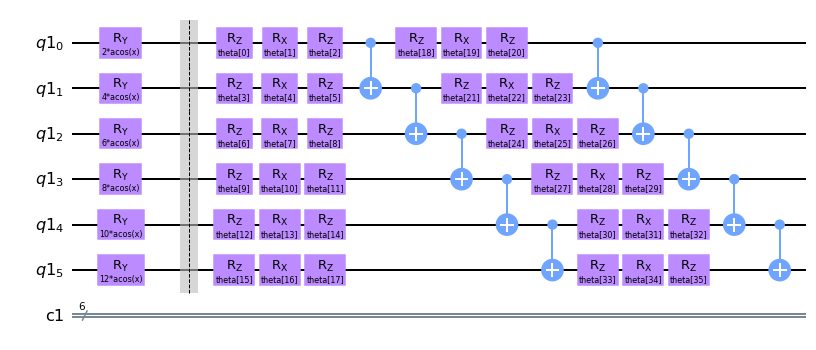

In [6]:
qnn[0].draw('mpl')

In [89]:
estimator_qnn=EstimatorQNN(
                circuit=qnn[0],
                input_params=qnn[1].parameters,
                weight_params=qnn[2].params
)

In [90]:
model=TorchConnector(estimator_qnn, initial_weights=np.random.uniform(0,2*np.pi,36))

In [91]:
optimizer=ADAM(model.parameters())

In [92]:
f_loss=MSELoss(reduction='mean')

In [93]:
model.train()

TorchConnector()

In [96]:
model(x[0,:])

QiskitMachineLearningError: 'Estimator job failed.'

In [64]:
x[0,:]

tensor([0.])

In [95]:
x=torch.linspace(0,0.9,20).reshape(20,1)
x


tensor([[0.0000],
        [0.0474],
        [0.0947],
        [0.1421],
        [0.1895],
        [0.2368],
        [0.2842],
        [0.3316],
        [0.3789],
        [0.4263],
        [0.4737],
        [0.5211],
        [0.5684],
        [0.6158],
        [0.6632],
        [0.7105],
        [0.7579],
        [0.8053],
        [0.8526],
        [0.9000]])

In [68]:
a

tensor([[10]])

In [79]:
optimizer = LBFGS(model.parameters())
def closure():
    optimizer.zero_grad()  # Initialize/clear gradients
    loss = f_loss(model(x[0]),a) # Evaluate loss function
    loss.backward()  # Backward pass
    print(loss.item())  # Print loss
    return loss



# Run optimizer step4
optimizer.step(closure)

RuntimeError: Found dtype Long but expected Float

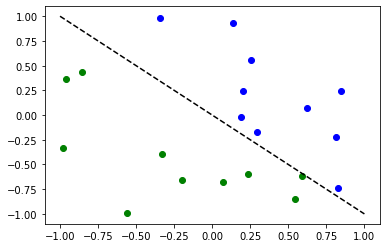

In [45]:
num_inputs = 2
num_samples = 20

# Generate random input coordinates (X) and binary labels (y)
X = 2 * algorithm_globals.random.random([num_samples, num_inputs]) - 1
y01 = 1 * (np.sum(X, axis=1) >= 0)  # in { 0,  1}, y01 will be used for SamplerQNN example
y = 2 * y01 - 1  # in {-1, +1}, y will be used for EstimatorQNN example

# Convert to torch Tensors
X_ = Tensor(X)
y01_ = Tensor(y01).reshape(len(y)).long()
y_ = Tensor(y).reshape(len(y), 1)

# Plot dataset
for x, y_target in zip(X, y):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()


In [46]:
X_

tensor([[-0.5588, -0.9909],
        [ 0.2517,  0.5529],
        [ 0.2383, -0.5968],
        [ 0.6204,  0.0766],
        [ 0.8130, -0.2233],
        [-0.8531,  0.4389],
        [-0.9610,  0.3624],
        [-0.1963, -0.6542],
        [ 0.5453, -0.8498],
        [ 0.1382,  0.9292],
        [-0.9815, -0.3314],
        [ 0.8477,  0.2444],
        [ 0.0678, -0.6746],
        [-0.3438,  0.9811],
        [ 0.1991,  0.2454],
        [ 0.1912, -0.0197],
        [ 0.2917, -0.1674],
        [ 0.8296, -0.7351],
        [ 0.5871, -0.6114],
        [-0.3318, -0.3937]])

In [47]:

y_

tensor([[-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.]])

In [78]:
a=torch.tensor([10])
a

tensor([10])

In [18]:
a=np.linspace(0,0.9,20)

In [31]:
for i in x:
    print(model(i))


tensor([0.0002], grad_fn=<_TorchNNFunctionBackward>)
tensor([0.0021], grad_fn=<_TorchNNFunctionBackward>)
tensor([0.0041], grad_fn=<_TorchNNFunctionBackward>)
tensor([0.0060], grad_fn=<_TorchNNFunctionBackward>)
tensor([0.0080], grad_fn=<_TorchNNFunctionBackward>)
tensor([0.0099], grad_fn=<_TorchNNFunctionBackward>)
tensor([0.0118], grad_fn=<_TorchNNFunctionBackward>)
tensor([0.0136], grad_fn=<_TorchNNFunctionBackward>)
tensor([0.0155], grad_fn=<_TorchNNFunctionBackward>)
tensor([0.0173], grad_fn=<_TorchNNFunctionBackward>)
tensor([0.0190], grad_fn=<_TorchNNFunctionBackward>)
tensor([0.0207], grad_fn=<_TorchNNFunctionBackward>)
tensor([0.0224], grad_fn=<_TorchNNFunctionBackward>)
tensor([0.0240], grad_fn=<_TorchNNFunctionBackward>)
tensor([0.0256], grad_fn=<_TorchNNFunctionBackward>)
tensor([0.0271], grad_fn=<_TorchNNFunctionBackward>)
tensor([0.0286], grad_fn=<_TorchNNFunctionBackward>)
tensor([0.0300], grad_fn=<_TorchNNFunctionBackward>)
tensor([0.0313], grad_fn=<_TorchNNFunctionBack

In [20]:
model(a)


tensor([[-0.0223]], grad_fn=<_TorchNNFunctionBackward>)

In [70]:

import numpy as np
import matplotlib.pyplot as plt

from torch import Tensor
from torch.nn import Linear, CrossEntropyLoss, MSELoss
from torch.optim import LBFGS

from qiskit import QuantumCircuit
from qiskit.utils import algorithm_globals
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector

# Set seed for random generators
algorithm_globals.random_seed = 42
feature_map = ZZFeatureMap(num_inputs)
ansatz = RealAmplitudes(num_inputs)
qc = QuantumCircuit(num_inputs)
qc.compose(feature_map, inplace=True)
qc.compose(ansatz, inplace=True)
qc.draw("mpl")
qnn1 = EstimatorQNN(
    circuit=qc, input_params=feature_map.parameters, weight_params=ansatz.parameters
)

# Set up PyTorch module
# Note: If we don't explicitly declare the initial weights
# they are chosen uniformly at random from [-1, 1].
initial_weights = 0.1 * (2 * algorithm_globals.random.random(qnn1.num_weights) - 1)
model1 = TorchConnector(qnn1, initial_weights=initial_weights)
print("Initial weights: ", initial_weights)

Initial weights:  [ 0.05479121 -0.01222431  0.07171958  0.03947361 -0.08116453  0.09512447
  0.05222794  0.05721286]


In [71]:
model1(X_[0, :])

tensor([-0.3833], grad_fn=<_TorchNNFunctionBackward>)

In [73]:
model1(X_)

tensor([[-0.3833],
        [-0.3797],
        [-0.3408],
        [-0.9776],
        [-0.8967],
        [-0.5416],
        [-0.5930],
        [ 0.1336],
        [ 0.1328],
        [-0.3805],
        [-0.8122],
        [ 0.5893],
        [-0.1411],
        [ 0.3003],
        [-0.0901],
        [ 0.9564],
        [ 0.8928],
        [ 0.0773],
        [ 0.2459],
        [ 0.4743]], grad_fn=<_TorchNNFunctionBackward>)

In [72]:
y_

tensor([[-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [-1.],
        [-1.]])

In [18]:
solver_adam2=dqc(qubit=6,depth=3, backend=backend, x=np.linspace(0,0.9,20),Lambda=8, kappa=0.1)
init=np.random.uniform(0, 2*np.pi, 54)
adam2=ADAM(maxiter=100, tol=1e-7, lr=0.001)
adam2.minimize(fun=solver_adam2.loss, x0=init)

2.4222554692661276
2.5469252423029514
2.804020774974529
4.015323934527976
2.044170737724193
3.37760721122377
2.0073335795209952
3.046021103921232
2.75085597946837
3.36747679000081
2.869655599289389
3.326092137219883
2.30139754383412
3.117456918284689
3.6017887336799737
2.1177874507722603
1.8079464626447
2.823475516909214
3.123538482724249
3.35220699829413
1.9932445615301373
1.4768829422846237
1.5980231343849447
1.504698205252818
2.096650048589392
2.3914927414370224
3.2342243557410013
2.1221471015986486
2.8102389596013095
3.434005183977302
2.139496698120595
3.536729665139542
2.2539028198759654
2.814963026912578
2.946266538390708
2.164840003139643
3.353552934457098
2.7478212119621928
2.6056397049168263
2.9525460387993734
1.9701824717533243
3.022589644410249
3.7115192065952143
1.3743440100443496
2.7576675740531162
2.458414565324246
2.584694700805796
2.533060686169194
2.7165959678416725
1.424425562880046
2.7871678024905733
2.268203208329552
2.683797237928529
2.9193568168296977
2.0434382267

KeyboardInterrupt: 

In [41]:
adam=ADAM(maxiter=200, tol=1e-7, lr=0.001)
adam.minimize(fun=loss_adam, x0=np.random.uniform(0,2*np.pi, 45))


5.92456172433208
6.2417484306114694
5.819867054885226
7.793085432755353
11.034990162697897
7.432654871262531
6.155831820001785
8.19295101017208
10.178391291850197
5.001247151465394
5.859091706173144
9.389324380984016
3.5763557879777963
7.049290140380187
6.844995585548075
9.103227146107141
8.429055353671044
7.8675633005673875
5.821646521434461
8.090260125655279
5.5793432931213705
6.602060508256583
6.669436293940201
6.144008072573036
8.226047460369335
7.87791424974567
7.088565675678609
8.058626441344233
7.657730962277711
6.758147702969052
6.004514346258157
6.0760286676804025
5.401362666658928
11.43555670192914
8.457482911005842
8.199120189275849
10.020964155532553
6.137593924425042
8.510915500467492
9.111857088520727
5.158181997338948
5.925234359329644
8.016427521499367
7.026430578557852
5.52797191814898
4.545321283512449
7.599652270523153
7.896146583309642
7.152392983231157
5.3459416768276515
5.760208637490512
6.5144712222367875
7.575429783432743
11.422030763464848
7.177079654555378
9.3